<a href="https://colab.research.google.com/github/HirunaD/LangChain/blob/main/12_3_LangGraph_Stage3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langchain==0.3.24 -q
!pip install langchain-openai -q
!pip install langchain-community -q
!pip install langgraph -q

# !pip install langchain-tavily -q
# !pip install pyowm -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 20.0 MB/s eta 0:00:00


In [2]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage, ToolMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

In [3]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [4]:
import os
from google.colab import userdata

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

In [5]:
llm = ChatOpenAI(model = "gpt-4o-mini")

In [6]:
# from langchain_tavily import TavilySearch
# from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langchain.agents import load_tools

@tool
def addtion(a: int, b:int):
    """This is the addition function that adds 2 numbers"""
    return a + b

@tool
def subtraction(a: int, b: int):
    """This is the subtraction function that subtract 2 numbers"""
    return a - b

@tool
def multiplication(a: int, b: int):
    """This is the multiplication function that multiply 2 numbers"""
    return a * b

@tool
def division(a: int, b: int):
    """This is the division function that divide 2 numbers"""
    return a / b

# os.environ["OPENWEATHERMAP_API_KEY"] = userdata.get('OPENWEATHERMAP_API_KEY')
# os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')

# # Initialize DuckDuckGo search tool
# search_tool = TavilySearch()

# # Initialize OpenWeatherMap tool
# weather = OpenWeatherMapAPIWrapper()

# weather_tool = load_tools(["openweathermap-api"], llm)[0]

In [7]:
tools = [addtion, subtraction, multiplication, division]
# tools = [search_tool, weather_tool]

In [8]:
llm_with_tools = llm.bind_tools(tools)

In [9]:
def llm_call(state:AgentState) -> AgentState:
    system_prompt = SystemMessage(content=
        "You are an intelligent AI assistant."
    )
    response = llm_with_tools.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}


def decision(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

In [10]:
graph = StateGraph(AgentState)

graph.add_node("agent", llm_call)
tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)

graph.set_entry_point("agent")
graph.add_conditional_edges(
    "agent",
    decision,
    {
        "continue": "tools",
        "end": END,
    },
)
graph.add_edge("tools", "agent")

app = graph.compile()

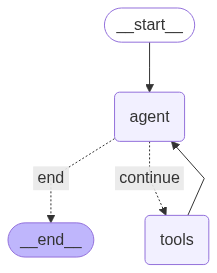

In [11]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [12]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [13]:
inputs = {"messages": [("user", "Add 40 and 12. Then multiply the result by 6.")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Add 40 and 12. Then multiply the result by 6.
================================== Ai Message ==================================
Tool Calls:
  addtion (call_2ZkgpwQ77cblftiLWGDDD8Ql)
 Call ID: call_2ZkgpwQ77cblftiLWGDDD8Ql
  Args:
    a: 40
    b: 12
================================= Tool Message =================================
Name: addtion

52
================================== Ai Message ==================================
Tool Calls:
  multiplication (call_yXCNj1CBPTrjO0vX2JNJk3kZ)
 Call ID: call_yXCNj1CBPTrjO0vX2JNJk3kZ
  Args:
    a: 52
    b: 6
================================= Tool Message =================================
Name: multiplication

312
================================== Ai Message ==================================

The result of adding 40 and 12 is 52, and when you multiply that by 6, the final result is 312.


In [14]:
inputs = {"messages": [("user", "What is the current temperature in Colombo?")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What is the current temperature in Colombo?
================================== Ai Message ==================================

I currently don't have access to real-time weather data. However, you can easily check the current temperature in Colombo using a weather website or a mobile app.
